In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

TESTING_WINDOW_SIZES = ['10min', '15min', '30min', '1h', '2h']
DATA_FOLDER          = './datasets/ambient_measurements/2022'
DATA_FILENAMES       = ['hum.csv', 'temp.csv']
VARIABLE_NAMES       = ['hum_level', 'temp_level']
PREFER_MAE_OVER_MSE  = False
SPLIT_DATE           = '2022-05-29 00:00:00'

In [2]:
data = pd.read_csv(f"{DATA_FOLDER}/{DATA_FILENAMES[0]}", index_col=0, parse_dates=True)
data.head()

,hum_level
time,
2022-05-09 21:22:18,50.23
2022-05-09 21:24:48,50.30
2022-05-09 21:27:18,50.33
2022-05-09 21:32:18,50.37
2022-05-09 21:37:18,50.41


# Separate the data into two parts, one for the training set and the other for the test set.

In [3]:
# Split the data into training and testing sets
train = deepcopy(data[:SPLIT_DATE])
test = deepcopy(data[SPLIT_DATE:])

## Find the best window size for the rolling average

In [8]:
for window_size in TESTING_WINDOW_SIZES:
    print(f"Window size: {window_size}")
    moving_average = train[VARIABLE_NAMES[0]].rolling(window=window_size).mean()
    #add the moving average to the dataset as a column
    train[f'moving_average_{window_size}'] = moving_average

train.columns

Window size: 10min
Window size: 15min
Window size: 30min
Window size: 1h
Window size: 2h


Index(['hum_level', 'moving_average_10min', 'moving_average_15min',
       'moving_average_30min', 'moving_average_1h', 'moving_average_2h'],
      dtype='object')

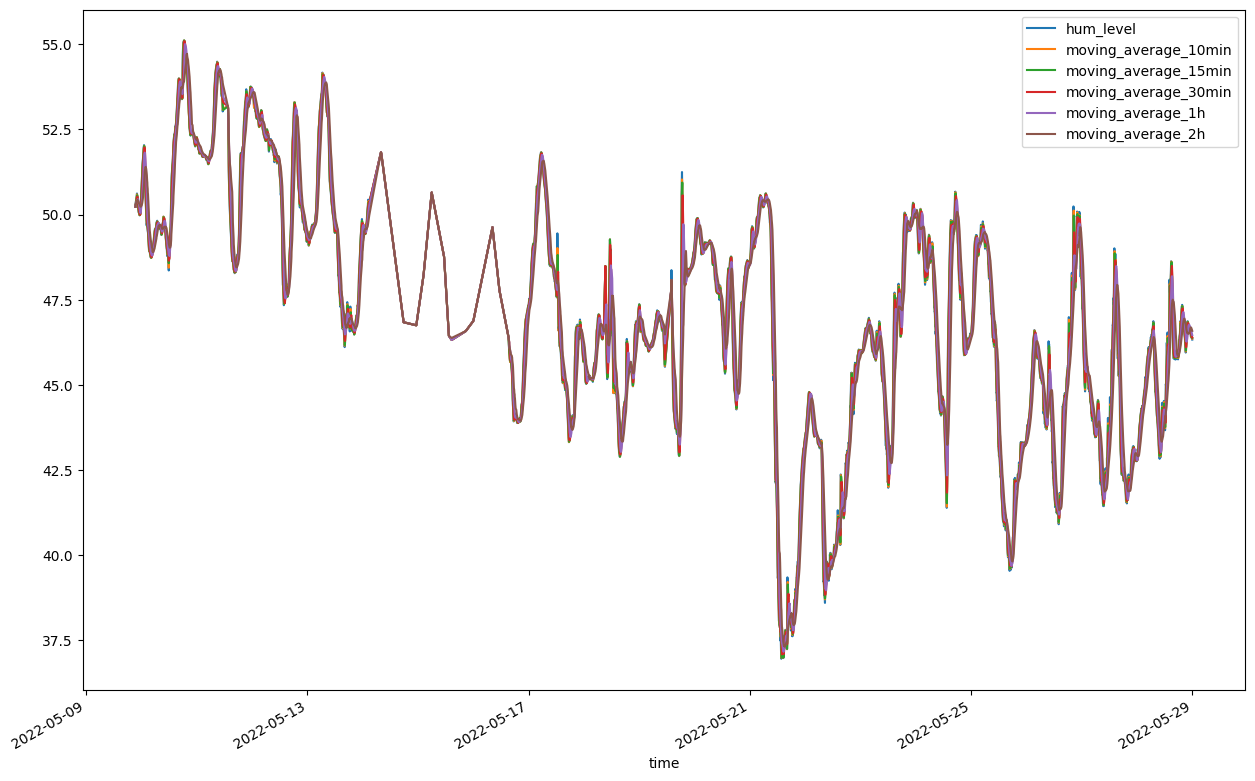

In [5]:
#plot the different moving averages vs the original data
train.plot(subplots=False, figsize=(15, 10))
plt.show()

In [9]:
#calculate the mean absolute error for each window size, and the mean squared error
mae = {}
mse = {}
for window_size in TESTING_WINDOW_SIZES:
    train[f"error_{window_size}"] = np.abs(train['hum_level'] - train[f"moving_average_{window_size}"])
    train[f"error_{window_size}"] = train[f"error_{window_size}"].replace([np.inf, -np.inf], np.nan)
    train[f"error_{window_size}"] = train[f"error_{window_size}"].fillna(0)
    mean_absolute_error = train[f"error_{window_size}"].mean()
    mean_squared_error = np.sqrt((train[f"error_{window_size}"]**2).mean())
    mae[window_size] = mean_absolute_error
    mse[window_size] = mean_squared_error
    print(f"Mean Absolute Error for {window_size}: {mean_absolute_error}")
    print(f"Mean Squared Error for {window_size}: {mean_squared_error}")
    print('---'*10)

#get the best window size
best_window_size_by_mae = min(mae, key=mae.get)
best_window_size_by_mse = min(mse, key=mse.get)

if PREFER_MAE_OVER_MSE:
    best_window_size = best_window_size_by_mae
else:
    best_window_size = best_window_size_by_mse
print(f"Best window size by Mean Absolute Error: {best_window_size_by_mae}")
print(f"Best window size by Mean Squared Error: {best_window_size_by_mse}")

Mean Absolute Error for 10min: 0.06939566734364425
Mean Squared Error for 10min: 0.1111498260721041
------------------------------
Mean Absolute Error for 15min: 0.11034562679938398
Mean Squared Error for 15min: 0.17092462270421122
------------------------------
Mean Absolute Error for 30min: 0.2216741564039252
Mean Squared Error for 30min: 0.32963130374282307
------------------------------
Mean Absolute Error for 1h: 0.40271909411272955
Mean Squared Error for 1h: 0.5773639411629181
------------------------------
Mean Absolute Error for 2h: 0.6935853188814799
Mean Squared Error for 2h: 0.9441604856155769
------------------------------
Best window size by Mean Absolute Error: 10min
Best window size by Mean Squared Error: 10min


## Differencing

Since the seasonality period is 24 h, you will subtract the value at time *t* – 24h from the value at time *t*. That is done with the code below.

In addition, you will need to align the result with the `time` array. Since you can only do time differencing for `t >= 24h`, you will need to truncate the first 24h time steps of the `time` array.

You can plot the result to visualize the values

<Axes: xlabel='time'>

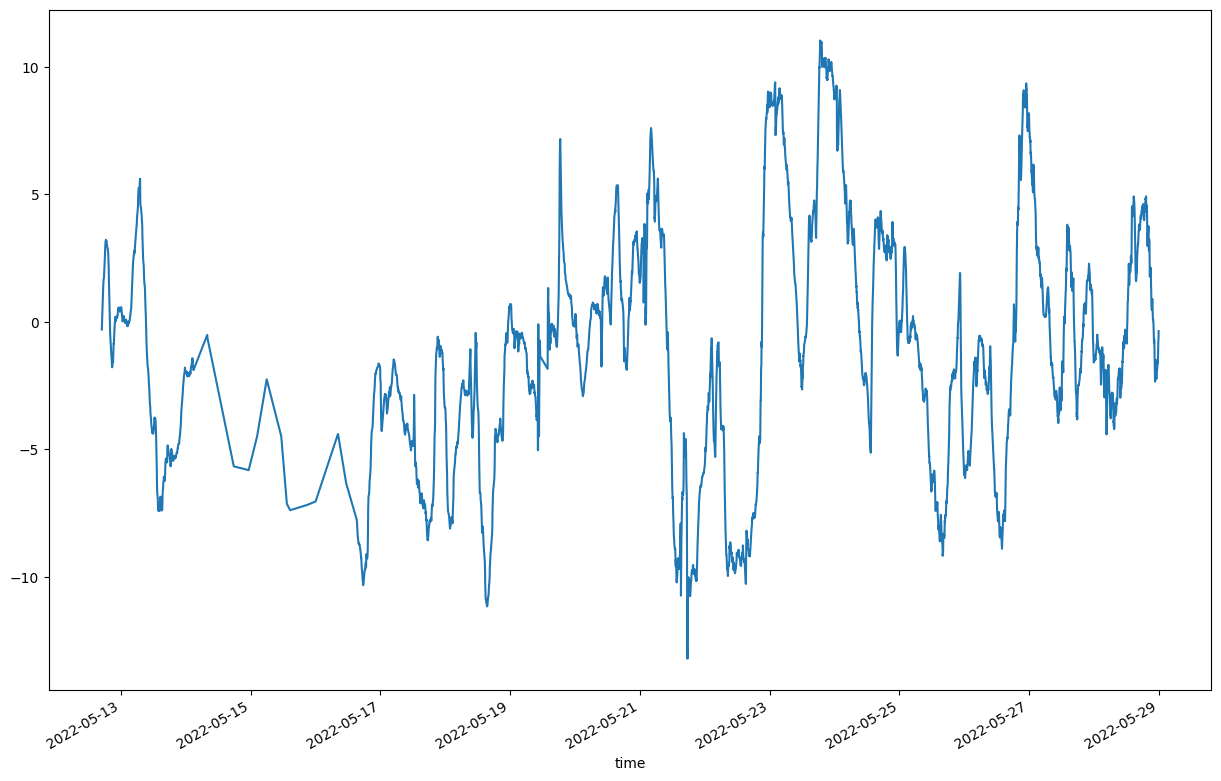

In [10]:
#apply differencing with a period of 24 hours
train['hum_level_diff'] = train['hum_level'].diff(periods=720)
train['hum_level_diff'].plot(figsize=(15, 10))

In [ ]:
#apply moving average with the best window size to the differenced train
diff_moving_average = train['hum_level_diff'].rolling(window=best_window_size).mean()

#plot the moving average vs the differenced train
plt.figure(figsize=(15, 10))
plt.plot(train['hum_level_diff'], label='hum_level_diff')
plt.plot(diff_moving_average, label=f'moving_average_{best_window_size}')
plt.legend()
plt.show()